# Spatial Data Reconstruction
`climatrix` provides tools for reconstructing spatial fields from sparse data onto a dense grid (or another sparse grid) using various methods, such as:
- Inverse Distance Weighting (IDW)
- Ordinary Kriging (OK)
- SIREN (Sinusoidal Representation Networks)

This notebook presents examples of how to use these methods.

In [1]:
import climatrix as cm
import xarray as xr

### ⬇️ Download DATASET first

1. You can either download first ERA5-Land directly from [CDS](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land?tab=overview) 
2. or use the `climatrix` CLI 

```bash
cm dataset config cds
```

and then

```bash
cm dataset download era5-land --year 2015 --month 10 --day 10 --hour 14 --target ./era5-land.nc
```

## Loading a Dataset

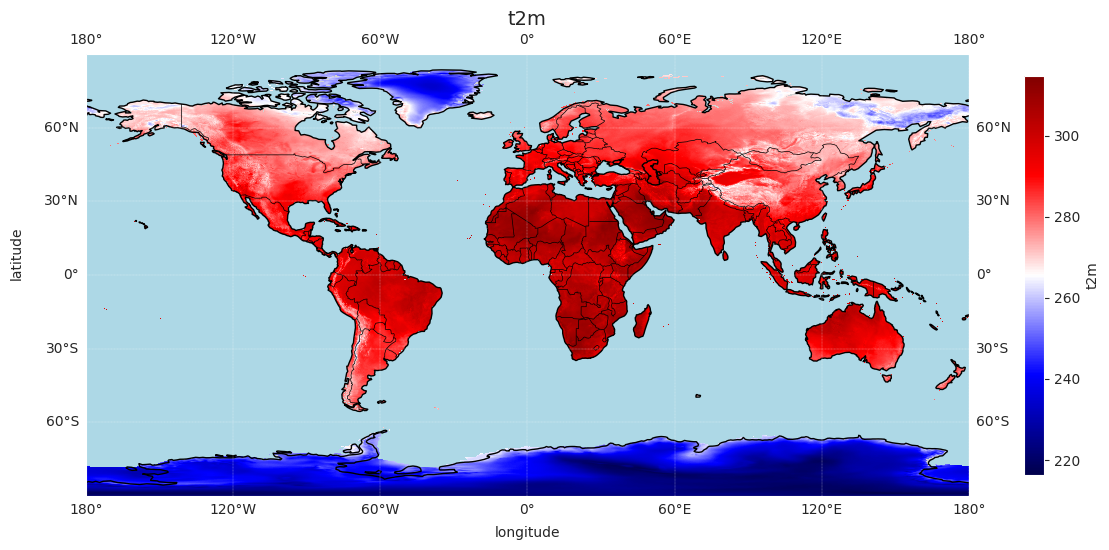

<GeoAxes: title={'center': 't2m'}>

In [2]:
xr_dset = xr.open_dataset("era5-land.nc")
dset = xr_dset.cm.to_signed_longitude()
dset.plot()

## Sampling training data

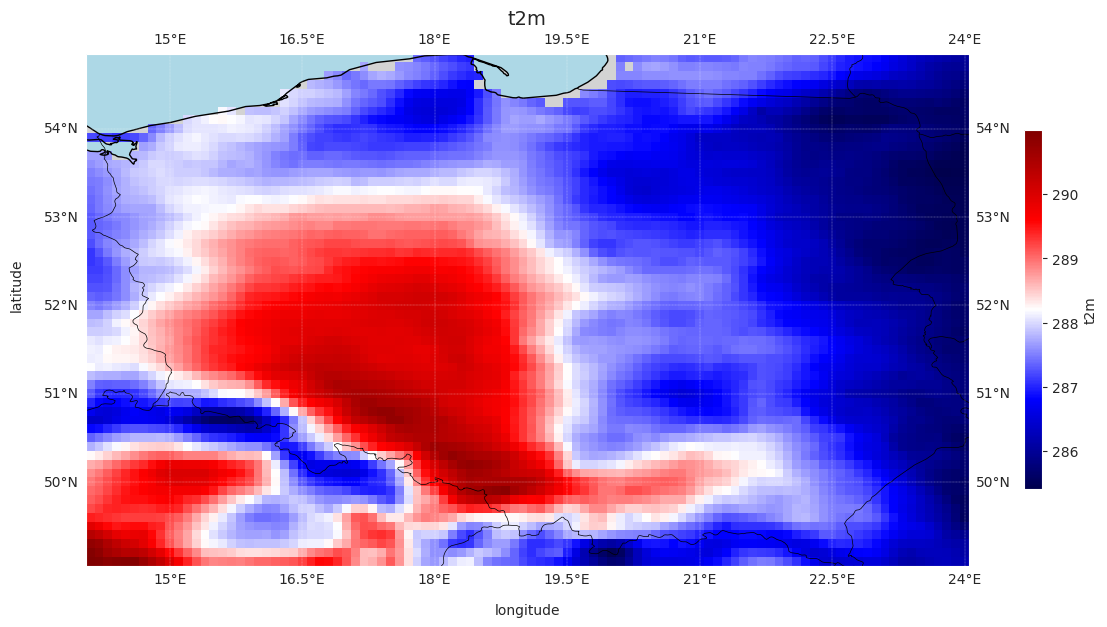

<GeoAxes: title={'center': 't2m'}>

In [3]:
poland = dset.subset(north=54.85, south=49.02, west=14.07, east=24.02)
poland.plot()

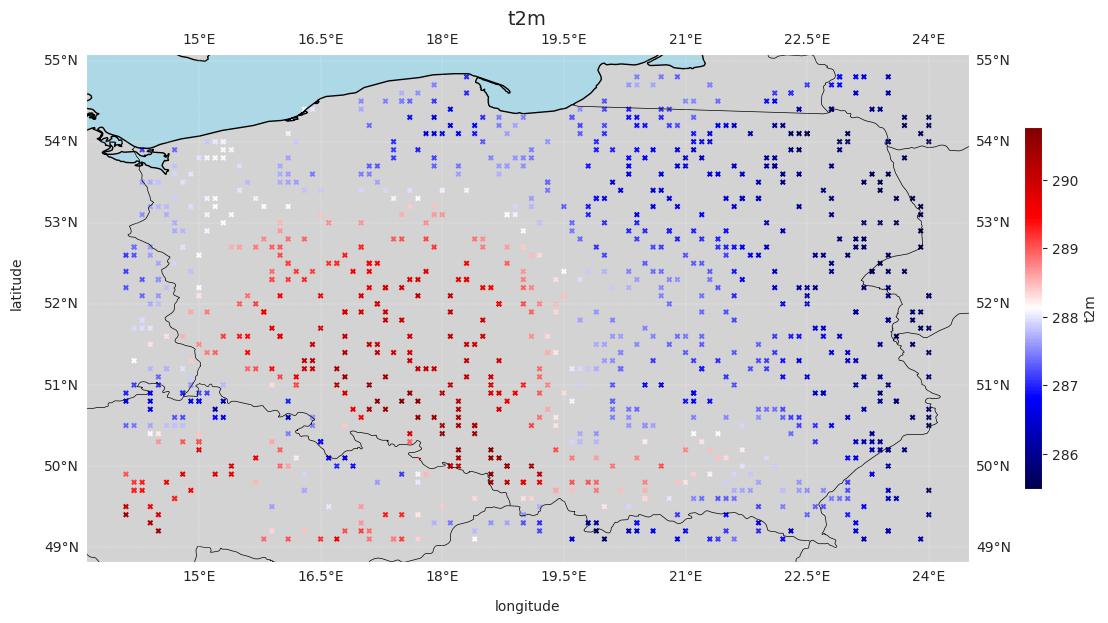

<GeoAxes: title={'center': 't2m'}>

In [4]:
sparse = poland.sample_uniform(number=1_000, nan="resample")
sparse.plot()

## Reconstruction using the IDW (Inverse Distance Weighting) method

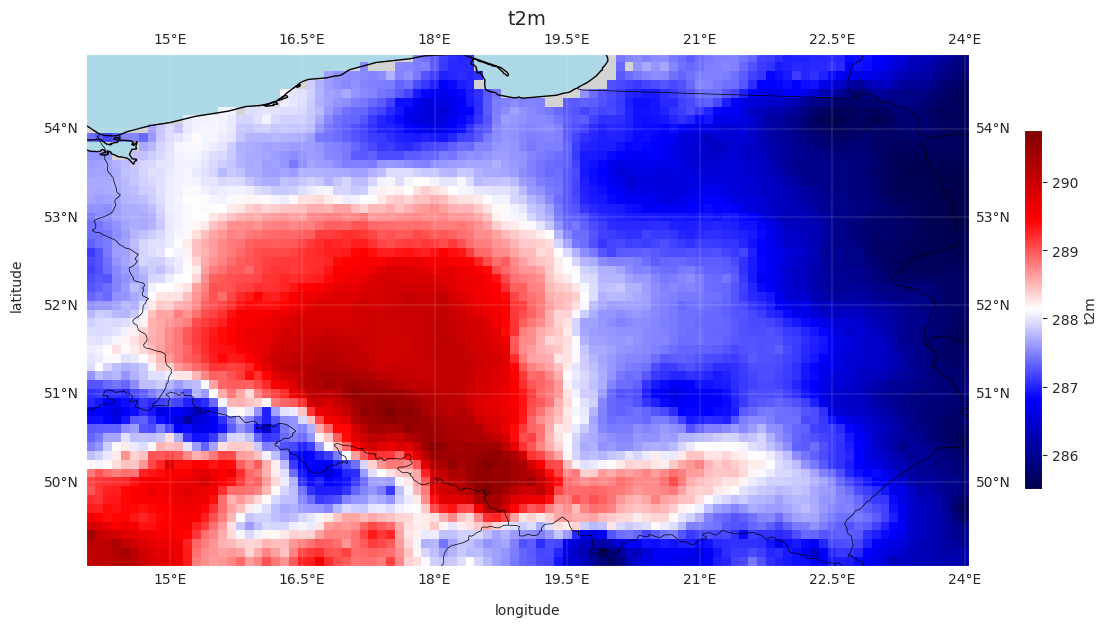

<GeoAxes: title={'center': 't2m'}>

In [5]:
cm_reconstructed_idw = sparse.reconstruct(
    target=poland.domain,
    method='idw', 
    k=7,
)


masked_nans = cm_reconstructed_idw.mask_nan(poland)
masked_nans.plot()

## Reconstruction using the Ordinary Kriging (OK) method

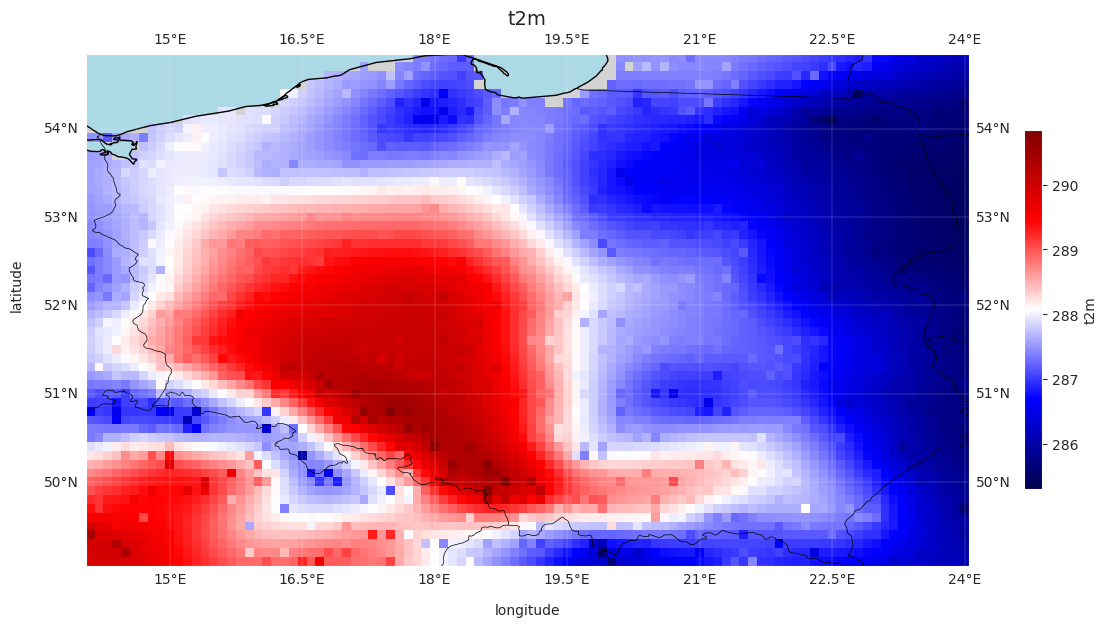

<GeoAxes: title={'center': 't2m'}>

In [6]:
cm_reconstructed_kriging = sparse.reconstruct(
    target=poland.domain,
    method='ok',
    weight=True
)

without_nans = cm_reconstructed_kriging.mask_nan(poland)
without_nans.plot()

## Reconstruction using the SIREN (Sinusoidal Representation Networks) method

02-06-2025 12:41:40 WARNING | climatrix.reconstruct.siren.dataset | Only 1000 points available, but requested 1024 on-surface points. Reducing on_surface_points to match available data.
02-06-2025 12:41:40 INFO | climatrix.reconstruct.siren.dataset | Created 3D points from coordinates and values: (1000, 3)
02-06-2025 12:41:41 INFO | climatrix.reconstruct.siren.dataset | Normalized 3D on-surface points.
02-06-2025 12:41:41 INFO | climatrix.reconstruct.siren.dataset | Created dataset with 1000 total on-surface points
02-06-2025 12:41:41 INFO | climatrix.reconstruct.siren.siren | Using checkpoint path: /storage/tul/projects/climatrix/examples/siren_checkpoint.pt
02-06-2025 12:41:41 INFO | climatrix.reconstruct.siren.siren | Initializing 3D SIREN model
02-06-2025 12:41:41 INFO | climatrix.reconstruct.siren.siren | Loading checkpoint from /storage/tul/projects/climatrix/examples/siren_checkpoint.pt...
02-06-2025 12:41:41 INFO | climatrix.reconstruct.siren.siren | Checkpoint loaded successfu

/storage/tul/projects/climatrix/src/climatrix/reconstruct/siren/dataset.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.points_3d = torch.tensor(self.points_3d, dtype=torch.float32)


02-06-2025 12:41:41 INFO | climatrix.reconstruct.siren.siren | Processed 1000/5800 points
02-06-2025 12:41:42 INFO | climatrix.reconstruct.siren.siren | Processed 2000/5800 points
02-06-2025 12:41:43 INFO | climatrix.reconstruct.siren.siren | Processed 3000/5800 points
02-06-2025 12:41:43 INFO | climatrix.reconstruct.siren.siren | Processed 4000/5800 points
02-06-2025 12:41:44 INFO | climatrix.reconstruct.siren.siren | Processed 5000/5800 points


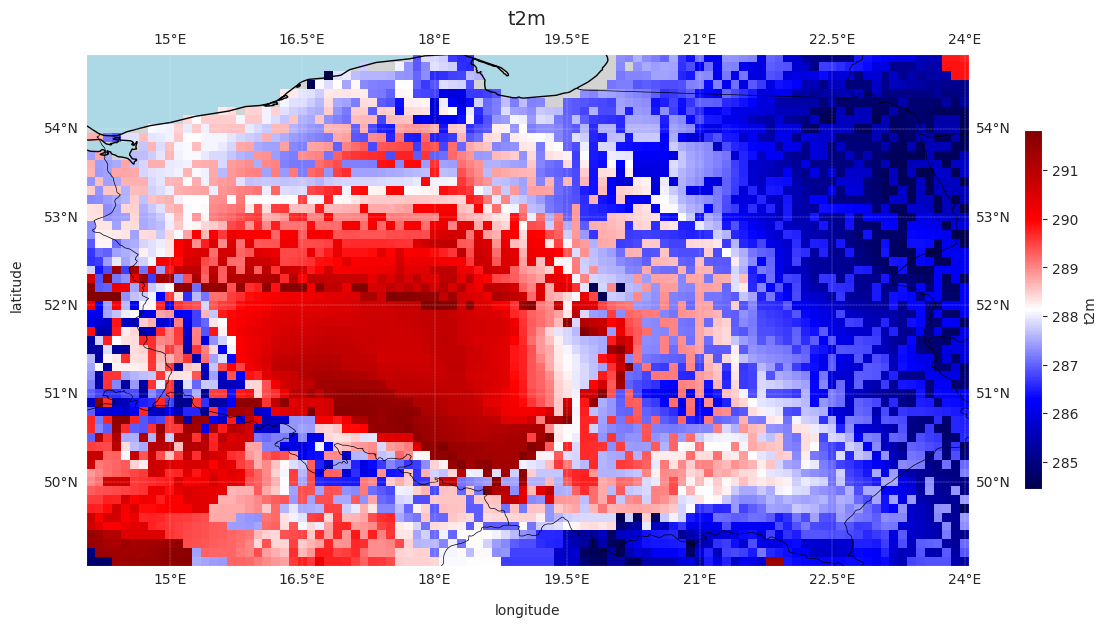

<GeoAxes: title={'center': 't2m'}>

In [11]:
cm_reconstructed_siren = sparse.reconstruct(
    poland.domain,
    method="siren",
    num_epochs=5_000,
    lr=5e-5,
    checkpoint="./siren_checkpoint.pt",
)

without_nans = cm_reconstructed_siren.mask_nan(poland)
without_nans.plot()


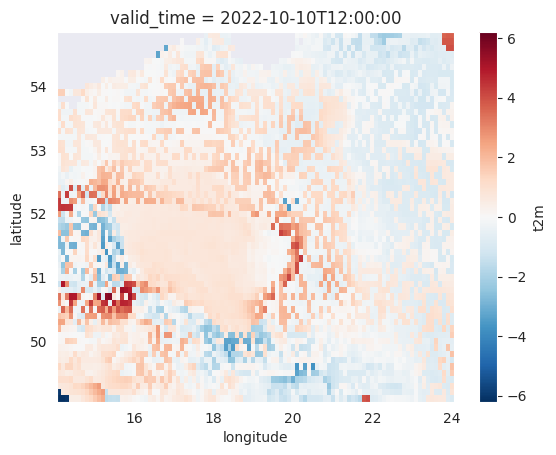

In [12]:
cm.Comparison(without_nans, poland).plot_diff()